#Libraries, Dates and Data

In [1]:
#import libraries
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Dates
training_start = "2014-01-08"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-02"

In [3]:
#Download VW stock
y = ["VOW.DE"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1wk")
y = y['Adj Close'].rename("y")
y.head(1)

[*********************100%***********************]  1 of 1 completed


Date
2014-01-06    117.486717
Name: y, dtype: float64

In [16]:
#Dowload the control groups
stocks = ["META", "DIS", "NVS", "AMZ"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1wk")
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AMZ,DIS,META,NVS
Date,,,,
2014-01-06 00:00:00+00:00,290.200012,68.839661,57.821182,48.912113
2014-01-13 00:00:00+00:00,296.000000,67.552170,56.184544,48.815895
2014-01-20 00:00:00+00:00,287.000000,66.401642,54.338337,48.010124
2014-01-27 00:00:00+00:00,271.299988,66.301208,62.441689,47.547096
2014-02-03 00:00:00+00:00,260.450012,69.095322,64.188095,48.659561


In [17]:
#Combine everything
X.index = X.index.tz_localize(None)
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,117.486717,290.200012,68.839661,57.821182,48.912113
2014-01-13,118.963638,296.000000,67.552170,56.184544,48.815895
2014-01-20,111.518990,287.000000,66.401642,54.338337,48.010124
2014-01-27,108.715912,271.299988,66.301208,62.441689,47.547096
2014-02-03,110.011955,260.450012,69.095322,64.188095,48.659561


#Correlation Matrix

In [18]:
#Subset the training data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-27,115.840866,484.250000,111.611748,93.817215,66.314438
2015-08-10,113.291794,478.299988,99.669273,94.226372,65.502701
2015-08-17,103.850807,445.049988,91.930855,85.883514,62.357944
2015-08-24,107.312515,465.399994,95.316422,90.823364,62.862888
2015-08-31,100.672348,450.100006,93.911980,88.079010,60.434021


<Axes: >

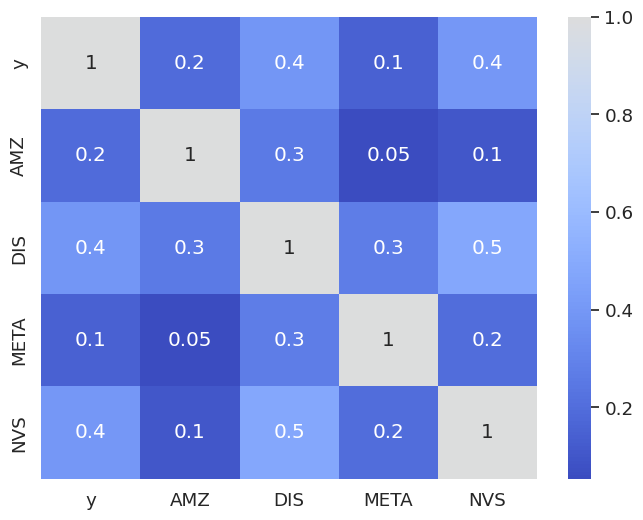

In [19]:
#Heatmap
plt.figure(figsize = (8,6))
sns.set_theme(font_scale = 1.2)
sns.heatmap(data = df_training.pct_change().dropna().corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm',
            center = True)

In [25]:
#Preparing final df
df_final = df.drop(columns = ["META","AMZ"])
df_final.head(0)

,y,DIS,NVS
Date,,,


#Google Causal Impact

In [26]:
#Get first and last date
print(df_final.head(1))
print(df_final.tail(10))

                     y        DIS        NVS
Date                                        
2014-01-06  117.486717  68.839661  48.912113
                     y         DIS        NVS
Date                                         
2015-07-13  127.579147  110.551422  67.631149
2015-07-27  115.840866  111.611748  66.314438
2015-08-10  113.291794   99.669273  65.502701
2015-08-17  103.850807   91.930855  62.357944
2015-08-24  107.312515   95.316422  62.862888
2015-08-31  100.672348   93.911980  60.434021
2015-09-07  104.637581   97.176620  61.712379
2015-09-14  101.553513   95.651245  61.776295
2015-09-21   72.727051   93.288803  58.363106
2015-09-28   63.663692   95.800064  59.615883


In [27]:
#Dates
training_start = "2014-01-06"
training_end = "2015-08-31"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-02"

In [28]:
#Define Pre and Post Period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [23]:
#CI
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87710D-01    |proj g|=  8.10947D-01

At iterate    5    f=  1.39414D-01    |proj g|=  2.08388D-01

At iterate   10    f=  1.31608D-01    |proj g|=  3.89846D-02

At iterate   15    f=  1.31049D-01    |proj g|=  2.40635D-03

At iterate   20    f=  1.31045D-01    |proj g|=  1.12398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   3.411D-07   1.310D-01
  F =  0.13104492868924403     

CONVERG

 This problem is unconstrained.
/home/jcketterer/anaconda3/envs/econmetrics_ci/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


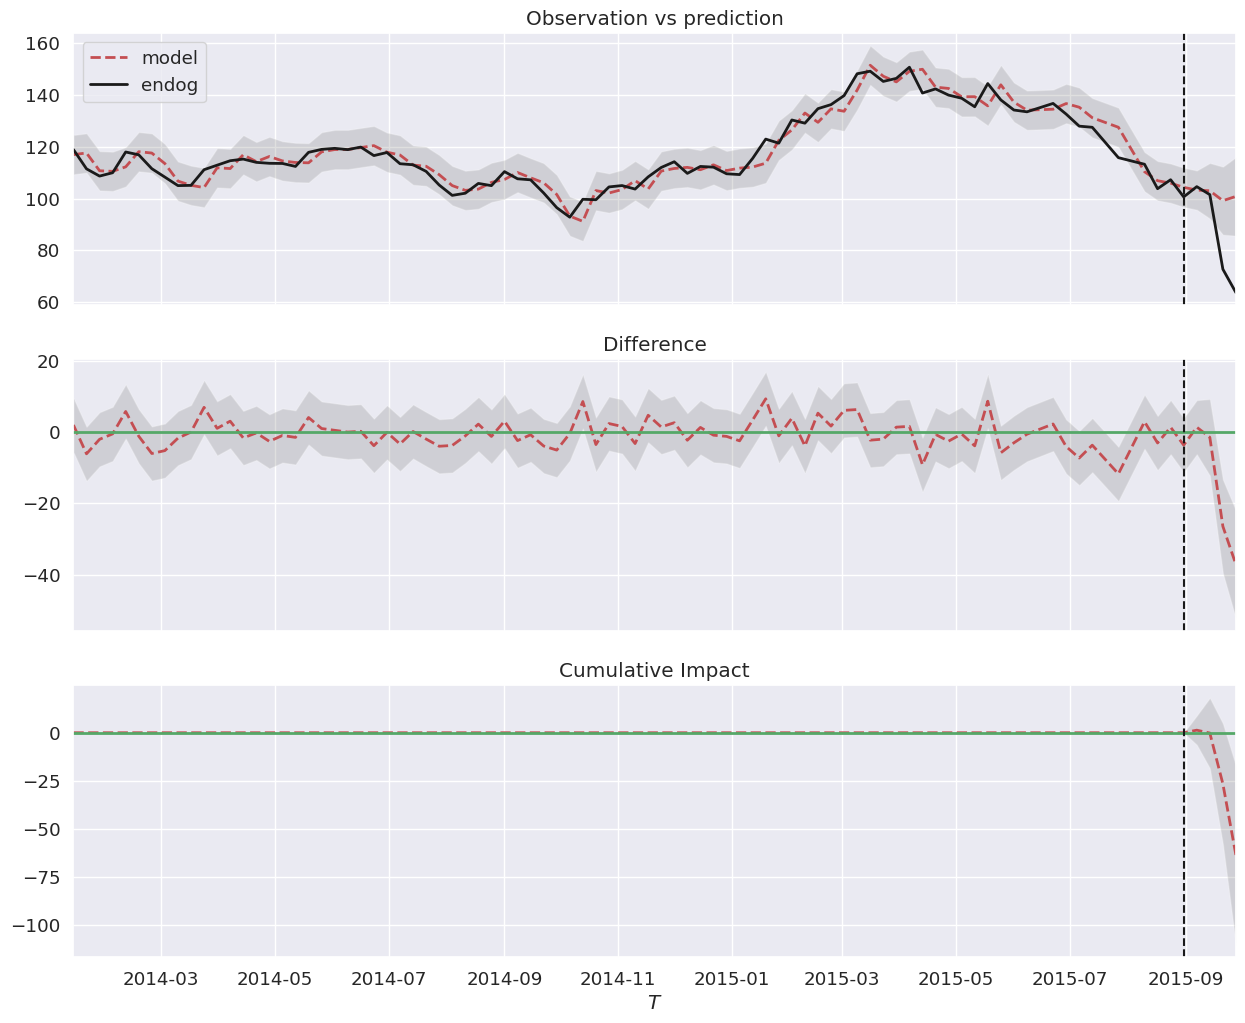

In [24]:
#Output
impact.run()
impact.plot()

In [29]:
#summary
print(impact.summary())

                                Average       Cumulative
Actual                               85              342
Predicted                           101              406
95% CI                        [89, 113]       [359, 453]
                                                        
Absolute Effect                     -15              -63
95% CI                        [-4, -27]      [-17, -110]
                                                        
Relative Effect                  -15.7%           -15.7%
95% CI                  [-4.2%, -27.2%]  [-4.2%, -27.2%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effect           100.0%                 
None
